# 3.3 ベイズ線形回帰
## 3.3.1 パラメータの分布

P152 ~ 154あたりの手順を再現

In [78]:
from __future__ import division
import matplotlib.mlab as mlab
import scipy.stats

### 計算部品

xから計画行列$\Phi$を作る関数

In [79]:
def design_matrix(x):
    el = []
    for xi in x:
        el.append([1, xi])
    return np.array(el)

$m_N = \beta S_N\Phi^{T}t$ を求める関数

In [80]:
def calc_mn(alpha, beta, x, t):
    Phi = design_matrix(x)
    Sn = calc_Sn(alpha, beta, x)
    return beta * Sn.dot(Phi.T).dot(t)

$S_N = (\alpha I + \beta\Phi^{T}\Phi)^{-1}$ を求める関数

In [81]:
def calc_Sn(alpha, beta, x):
    Phi = design_matrix(x)
    return np.linalg.inv(alpha*I + beta*Phi.T.dot(Phi))

-------------------------

In [82]:
# 単位行列
I = np.identity(2)

def plot_proba(title=None, mean=[0, 0], cov=I):
    x = np.linspace(-1, 1, 100)
    y = np.linspace(-1, 1, 100)
    X,Y = np.meshgrid(x, y)
    Z = np.zeros([len(x), len(y)])
    xindex = 0
    yindex = 0
    for xi in x:
        yindex = 0
        for yi in y:
            Z[yindex][xindex] = scipy.stats.multivariate_normal.pdf([xi,yi], mean, cov)
            yindex += 1
        xindex += 1
    plt.figure(figsize=(4, 3))
    plt.pcolor(X, Y, np.array(Z), cmap=plt.cm.jet)
    plt.xlabel('$w_0$')
    plt.ylabel('$w_1$')
    plt.colorbar()
    if title:
        plt.title(title)
    plt.show()

In [83]:
def plot_result_line(w):
    x = np.linspace(-1, 1, 100)
    y = w[0] + x*w[1]
    plt.plot(x, y)

In [84]:
def plot_lines(mean, cov):
    plot_result_line(np.random.multivariate_normal(mean, cov))
    plot_result_line(np.random.multivariate_normal(mean, cov))
    plot_result_line(np.random.multivariate_normal(mean, cov))
    plot_result_line(np.random.multivariate_normal(mean, cov))
    plot_result_line(np.random.multivariate_normal(mean, cov))
    plot_result_line(np.random.multivariate_normal(mean, cov))
    for x, t in zip(train_x, train_t):
        plt.plot(x, t, 'ro')
        
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.title(u'データ空間')

In [85]:
def uniform_sample():
    return (np.random.random() - 0.5) * 2

In [86]:
def f(x, a):
    return a[0] + a[1]*x + np.random.normal(0, 0.2)

In [87]:
def create_train_data():
    x = uniform_sample()
    t = f(x, [-0.3, 0.5])
    return x, t

## 初期状態

In [88]:
ALPHA = 2.0
SIGMA = 0.2
BETA = 1/SIGMA**2 # 精度パラメータ
train_x = []
train_t = []

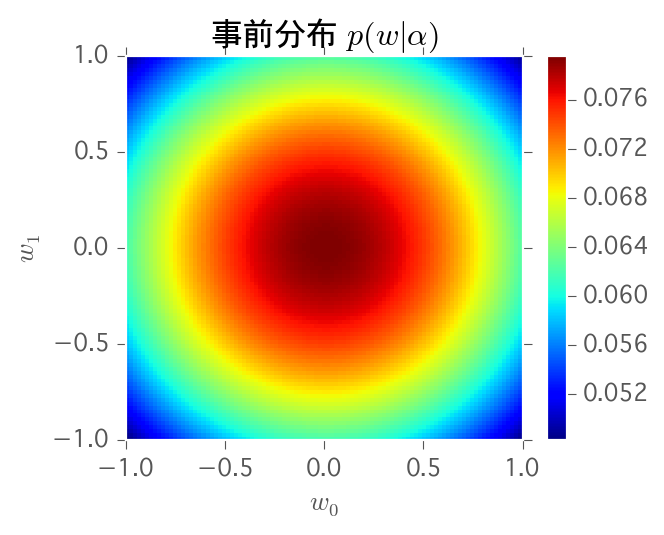

In [89]:
plot_proba(mean=[0, 0], cov=ALPHA*I, title=u'事前分布 $p(w|\\alpha)$')

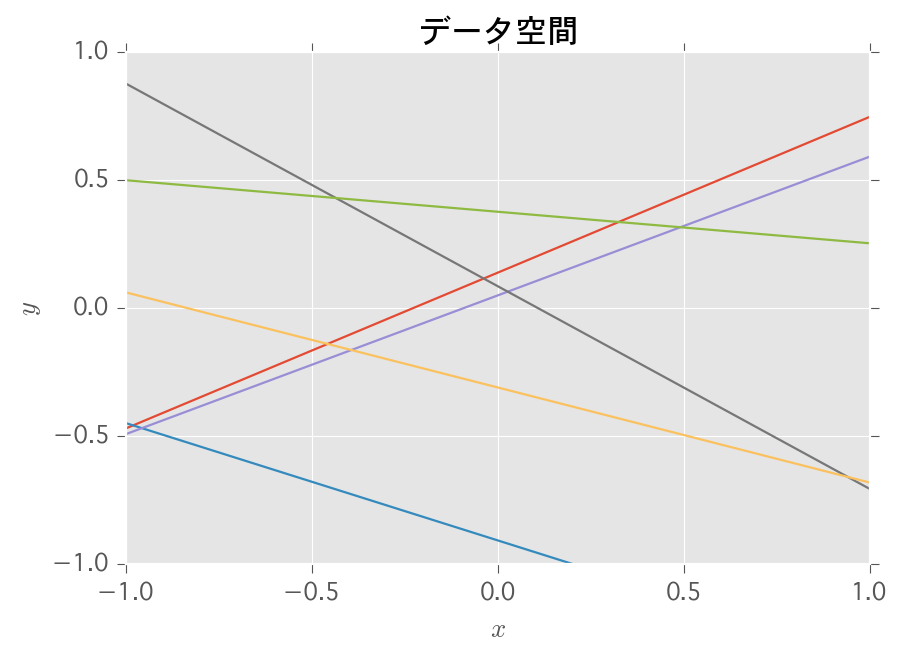

In [90]:
plot_lines([0, 0], SIGMA*I)

## データ取得後

In [91]:
x, t = create_train_data()
train_x.append(x)
train_t.append(t)

$m_1$と$S_1$を求める

In [92]:
m1 = calc_mn(alpha=ALPHA, beta=BETA, x=train_x, t=train_t)
s1 = calc_Sn(alpha=ALPHA, beta=BETA, x=train_x)

$p(w|t) = Norm(w|m_N, S_N)$ を求める

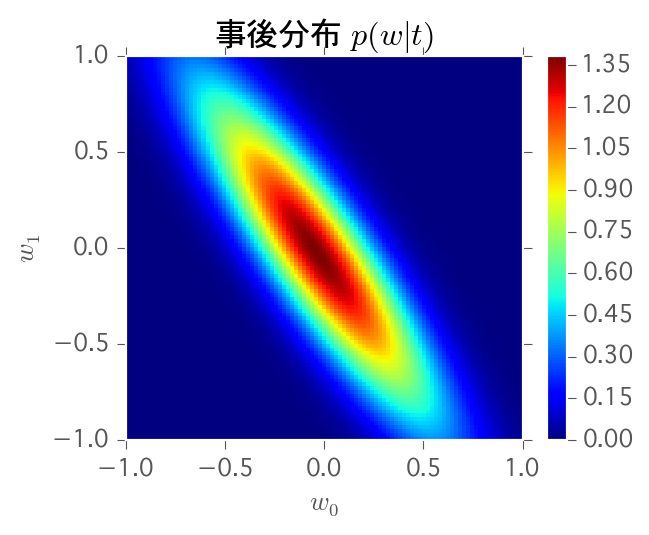

In [93]:
plot_proba(u'事後分布 $p(w|t)$', mean=m1, cov=s1)

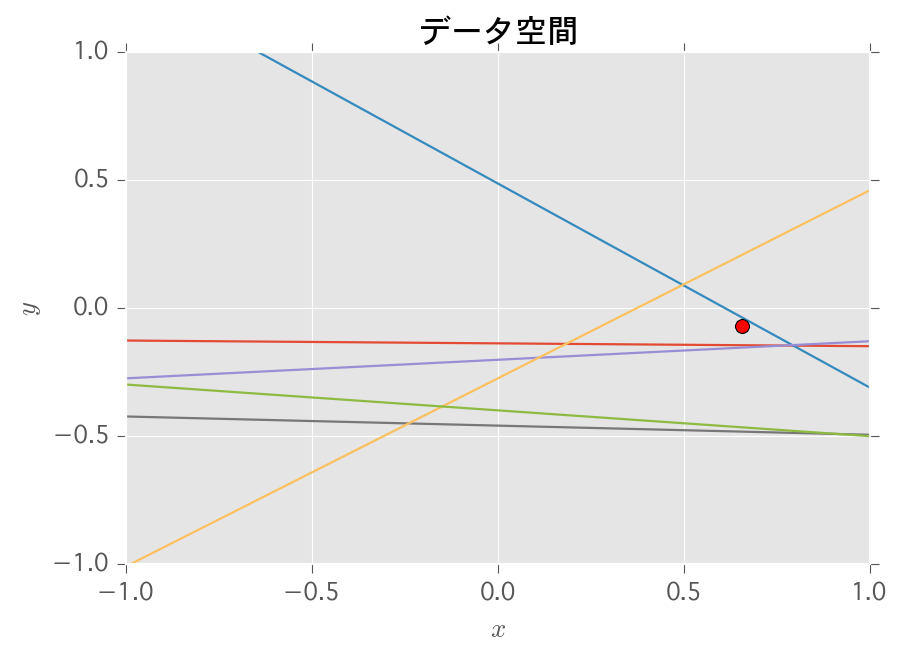

In [94]:
plot_lines(m1, s1)

## 2回目の更新

In [95]:
x, t = create_train_data()
train_x.append(x)
train_t.append(t)
m2 = calc_mn(alpha=ALPHA, beta=BETA, x=train_x, t=train_t)
s2 = calc_Sn(alpha=ALPHA, beta=BETA, x=train_x)

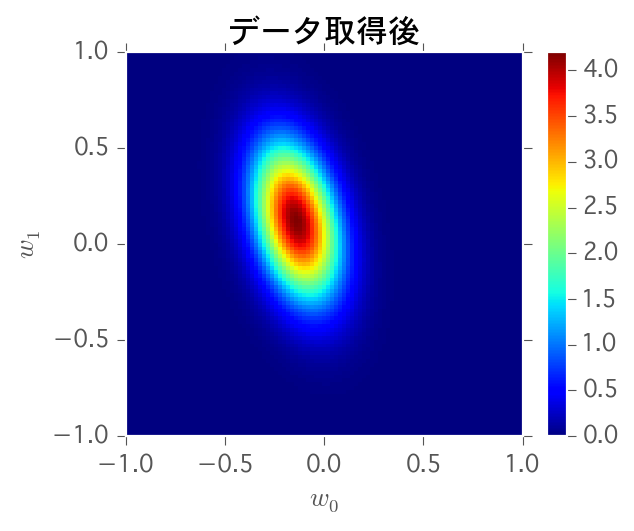

In [96]:
plot_proba(u'データ取得後', mean=m2, cov=s2)

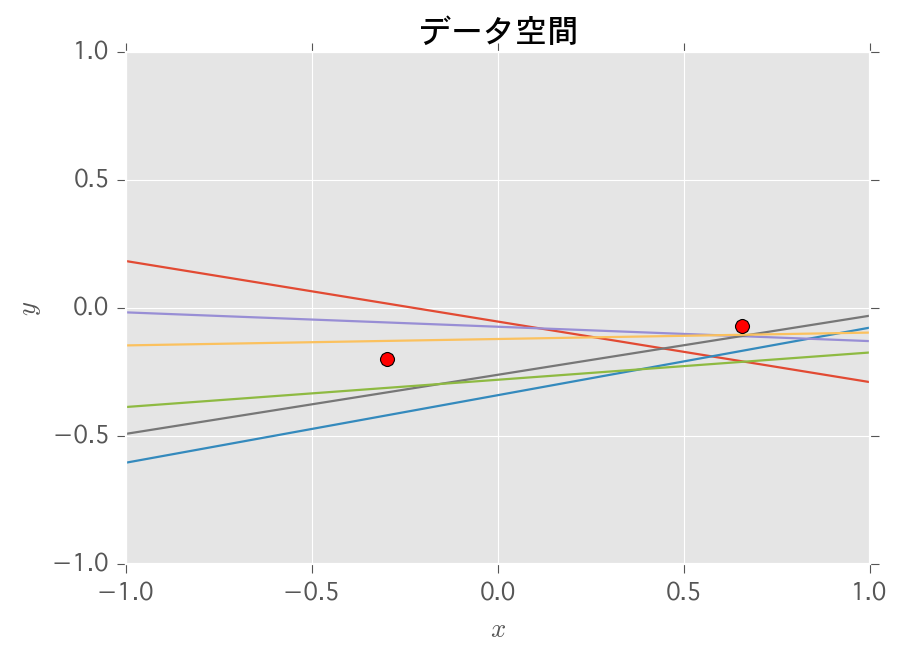

In [97]:
plot_lines(m2, s2)

## $p(w|t)$の収束

In [98]:
def update(train_x, train_t):
    x, t = create_train_data()
    train_x.append(x)
    train_t.append(t)
    mn = calc_mn(alpha=ALPHA, beta=BETA, x=train_x, t=train_t)
    sn = calc_Sn(alpha=ALPHA, beta=BETA, x=train_x)
    return mn, sn

In [99]:
update(train_x, train_t)
update(train_x, train_t)
update(train_x, train_t)
update(train_x, train_t)
update(train_x, train_t)
mn, sn = update(train_x, train_t)

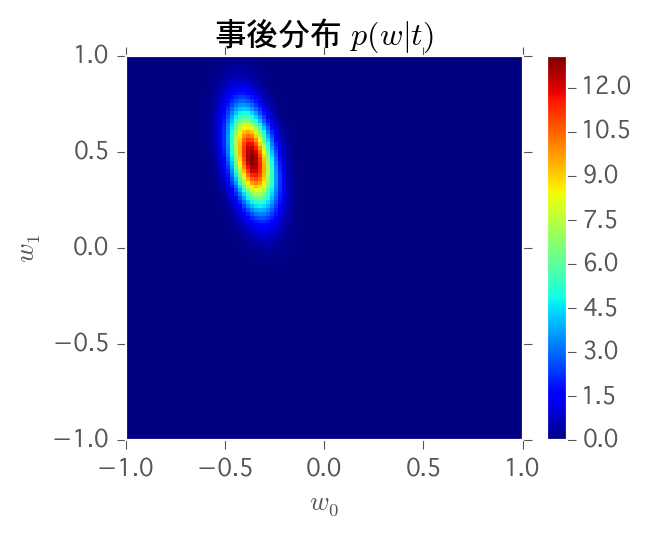

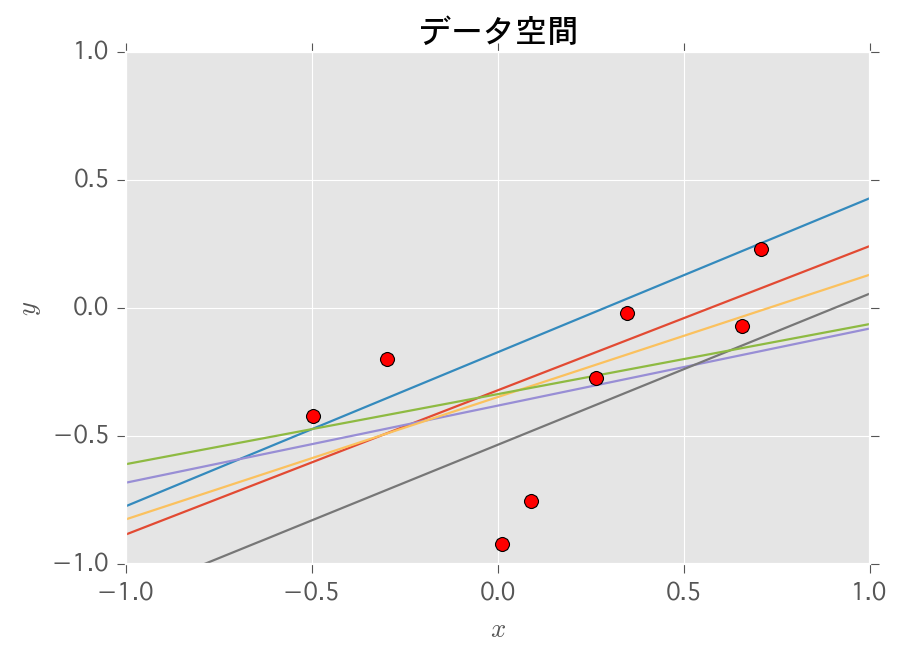

In [100]:
plot_proba(u'事後分布 $p(w|t)$', mean=mn, cov=sn)
plot_lines(mn, sn)